In [1]:
import numpy as np
import healpy as hp
import pymaster as nmt
from scipy import optimize
from scipy.linalg import det
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

from scripts.compute_covariance import compute_covariance

In [31]:
nside=256
freqs=np.arange(544,1088,step=10)
# nfreqs=len(freqs)
nfreqs=len(freqs)-1
lmax=2*nside #3*nside -1
almsize=hp.Alm.getsize(lmax)
r=3 #foreground model rank
# n_bins=10

In [35]:
ff=np.load("/home/iloveorcas/MASS_Thesis/results_2/ff_maps.npy")
sync=np.load("/home/iloveorcas/MASS_Thesis/results_2/sync_maps.npy")
hi_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/hi_maps.npy")*10
noise_maps= np.load("/home/iloveorcas/MASS_Thesis/results_2/noise_nf.npy")

In [20]:
noise_maps_1=noise_maps*1e4 # take only first chunk

In [5]:
sync.shape

(55, 786432)

In [36]:
fgds=sync/1e12 +ff
signal=fgds[:54] + hi_maps

In [37]:
cl_noise= compute_covariance(noise_maps_1, lmax, almsize, nfreqs)
cl_fgds= compute_covariance(fgds, lmax, almsize, nfreqs)
cl_hi=compute_covariance(hi_maps, lmax, almsize, nfreqs)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

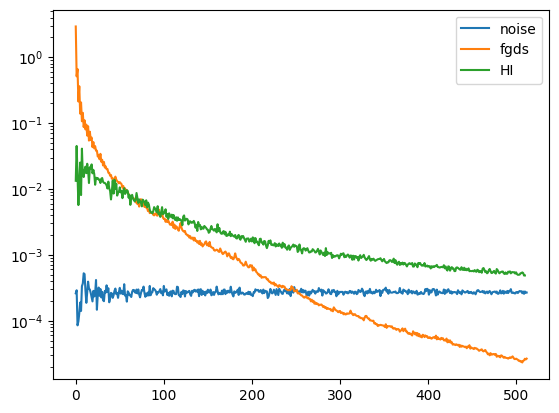

In [38]:
plt.plot(cl_noise[:,0,0], label='noise')
plt.plot(cl_fgds[:,0,0], label='fgds')
plt.plot(cl_hi[2:,0,0], label='HI')
plt.yscale('log')
plt.legend()

In [39]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((lmax+1, nfreqs, nfreqs))
    for l in range (lmax+1):
        print(f"Diagonalizing matrix {l}")
        cl_diag[l,:,:]= np.identity(nfreqs)*cl[l,:,:]
    return cl_diag

In [40]:
noise_d= diagonalize_matrices(cl_noise, nfreqs)
hi_d= diagonalize_matrices(cl_noise, nfreqs)

Diagonalizing matrix 0
Diagonalizing matrix 1
Diagonalizing matrix 2
Diagonalizing matrix 3
Diagonalizing matrix 4
Diagonalizing matrix 5
Diagonalizing matrix 6
Diagonalizing matrix 7
Diagonalizing matrix 8
Diagonalizing matrix 9
Diagonalizing matrix 10
Diagonalizing matrix 11
Diagonalizing matrix 12
Diagonalizing matrix 13
Diagonalizing matrix 14
Diagonalizing matrix 15
Diagonalizing matrix 16
Diagonalizing matrix 17
Diagonalizing matrix 18
Diagonalizing matrix 19
Diagonalizing matrix 20
Diagonalizing matrix 21
Diagonalizing matrix 22
Diagonalizing matrix 23
Diagonalizing matrix 24
Diagonalizing matrix 25
Diagonalizing matrix 26
Diagonalizing matrix 27
Diagonalizing matrix 28
Diagonalizing matrix 29
Diagonalizing matrix 30
Diagonalizing matrix 31
Diagonalizing matrix 32
Diagonalizing matrix 33
Diagonalizing matrix 34
Diagonalizing matrix 35
Diagonalizing matrix 36
Diagonalizing matrix 37
Diagonalizing matrix 38
Diagonalizing matrix 39
Diagonalizing matrix 40
Diagonalizing matrix 41
Di

In [41]:
delta_ell=10

In [16]:
def bin_spectra(cl,nside, delta):
    b= nmt.NmtBin.from_lmax_linear(lmax, nlb=delta)
    n_bins = b.get_n_bands()
    leff = b.get_effective_ells()
    cl_binned= np.zeros((n_bins, nfreqs, nfreqs))

    for i in range(nfreqs):
        for j in range(nfreqs):
            cl_binned[:, i, j] = b.bin_cell(cl[:, i, j])
            
    return leff,n_bins,cl_binned

In [66]:
leff,n_bins, noise_binned= bin_spectra(noise_d, nside, delta_ell)
*_, fgds_binned= bin_spectra(cl_fgds, nside, delta_ell)
*_, hi_binned= bin_spectra(cl_hi, nside, delta_ell)

In [ ]:
# np.save('fgds_binned.npy', fgds_binned)
# np.save('noise_binned.npy', noise_binned)

In [43]:
total=signal + noise_maps_1[:54]

In [44]:
c_l_hat= compute_covariance(total, lmax, almsize, 54)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4
Converting maps 5
Converting maps 6
Converting maps 7
Converting maps 8
Converting maps 9
Converting maps 10
Converting maps 11
Converting maps 12
Converting maps 13
Converting maps 14
Converting maps 15
Converting maps 16
Converting maps 17
Converting maps 18
Converting maps 19
Converting maps 20
Converting maps 21
Converting maps 22
Converting maps 23
Converting maps 24
Converting maps 25
Converting maps 26
Converting maps 27
Converting maps 28
Converting maps 29
Converting maps 30
Converting maps 31
Converting maps 32
Converting maps 33
Converting maps 34
Converting maps 35
Converting maps 36
Converting maps 37
Converting maps 38
Converting maps 39
Converting maps 40
Converting maps 41
Converting maps 42
Converting maps 43
Converting maps 44
Converting maps 45
Converting maps 46
Converting maps 47
Converting maps 48
Converting maps 49
Converting maps 50
Converting maps 51
Converting maps 52
Con

In [45]:
*_,c_bin= (bin_spectra(np.real(c_l_hat), nside, delta_ell))

In [46]:
c_hat=np.zeros((n_bins, nfreqs, nfreqs)) #clip any eigenvalues that are negative and put to zerp
for b in range(n_bins):
    
    cov = 0.5 * (c_bin[b] + c_bin[b].T) #symmetric or Hermitian?

    # Eigen-decomposition (since it's symmetric, use eigh)
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Zero out negative eigenvalues
    eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
    
    epsilon=1e-10

    # Reconstruct the covariance matrix
    c_hat[b] = (eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T)#+ epsilon*np.identity(nfreqs) 


In [ ]:
# np.save('binned_empirical.npy', c_hat)

In [47]:
np.all(eigvals_clipped >= 0)

np.True_

In [49]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= -tol) 
print("Is model PSD?", is_psd(c_hat))

Is model PSD? True


In [50]:
def pca(empirical, r):
    """
    Perform PCA on the covariance matrix.
    
    Parameters:
    ----------
    c_hat : np.ndarray
        Covariance matrix of shape (n_bins, n_freq, n_freq).
    
    r : int
        Number of principal components to retain.
    
    Returns:
    -------
    F : np.ndarray
        Matrix of shape (n_freq, r) containing the principal components.
    
    P_b : np.ndarray
        Matrix of shape (n_bins, r, r) containing the eigenvalues and eigenvectors.
    """
    # Perform PCA
    R_global = np.mean(empirical, axis=0)  # c_hat has shape (n_bins, n_freqs, n_freqs)
    #eigen decompositiom
    eigvals, eigvecs = np.linalg.eigh(R_global) #ascending order
    #Take the top r eigenvectors:
    F_i = eigvecs[:, -r:]  # largest eigenvectors
    epsilon=1e-6

    P_b = np.zeros((n_bins, r, r))
    for b in range(n_bins):
        P_b[b] =np.dot( F_i.T , np.dot(empirical[b] , F_i)) #projecting the empirical covariance into the subspace spanned by F.
        P_b[b] = 0.5 * (P_b[b] + P_b[b].T) + epsilon * np.eye(r)
    return eigvals,F_i, P_b*500


In [ ]:
def guess_params(nfreqs,n_bins, r):
    
    #Initial guess for F
    F_i= np.zeros((nfreqs, r))# N_channels x r
    # F_i= np.random.randn(nfreqs, r)

    # initial guess for P_l for each bin
    P_l=np.zeros((n_bins, r,r))
    for bin in range(n_bins):
        A = np.random.randn(r, r)
        #P_l[bin,:,:]= np.identity(r) #r x r #symmetric
        P_l[bin,:,:]=np.dot(A , A.T) + 1e-2 * np.eye(r) #strictly positive definite + symmetric
    return F_i, P_l


In [54]:
_,F_pca, P_b_pca = pca(c_hat,r)
# F_pca, P_b_pca = guess_params(nfreqs, n_bins,r)
print(F_pca.shape)
print(P_b_pca.shape)
params_pca = np.concatenate([F_pca.flatten(), P_b_pca.flatten()])
print(params_pca.shape)

# # Check recovery
# F_re = params_pca[:nfreqs * r].reshape((nfreqs, r))
# P_b_re = params_pca[nfreqs * r:].reshape((n_bins, r, r))
# print(F_re.shape)
# print(P_b_re.shape)
# print(F_re.size)
# print(P_b_re.size)

# np.allclose(F_pca, F_re)  # should return True
# np.allclose(P_b_pca, P_b_re)  # should return True


(54, 3)
(51, 3, 3)
(621,)


In [57]:
def model_covariance(F, P_b,C_HI, C_noise, n_bins):
    
    # F: (N_channels, r), P_b: (r, r), C_HI & C_noise: (N_channels, N_channels)
    C_b= np.zeros((n_bins, nfreqs, nfreqs))
    for b in range(n_bins):
        C_b[b,:,:]= C_HI[b,:,:]+C_noise[b,:,:] + np.dot(F,np.dot(P_b[b,:,:], F.T))
    return C_b

In [67]:
c_model= model_covariance(F_pca, P_b_pca,hi_binned,noise_binned, n_bins)

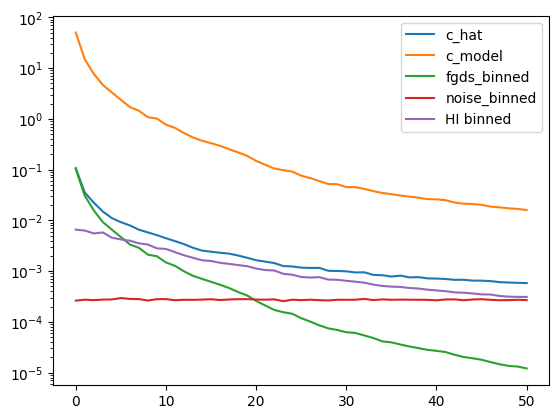

In [69]:
plt.plot(c_hat[:,10,10], label='c_hat')
plt.plot(c_model[:,10,10], label='c_model')
plt.plot(fgds_binned[:,10,10], label='fgds_binned')
plt.plot(noise_binned[:,10,10], label='noise_binned')
plt.plot(hi_binned[:,10,10], label='HI binned')
plt.yscale('log')
plt.legend()

In [70]:
def is_psd(P, tol=0):
    eigenvalues = np.linalg.eigvalsh(P)  # symmetric-optimized
    return np.all(eigenvalues >= tol)  
print("Is model PSD?", is_psd(c_model))

Is model PSD? True


In [72]:
def smica(params, hi,noise,empirical,  n_bins, nfreqs, r):
    
    # Reshape the flattened params back into F_init and P_b_init
    
    F_i = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])

        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm  # symmetric scaling"""
    
    
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
                
    # === Compute the cost function ===            
    cost=0
    # model=np.zeros((n_bins, nfreqs, nfreqs))
    # model_inv=np.zeros((n_bins, nfreqs, nfreqs))
    
    # term=np.zeros(n_bins)
    for b in range(n_bins):
        model=  hi[b]+noise[b] + np.dot(F_i, np.dot(P_b[b], F_i.T))
        model_inv= np.linalg.inv(model)
        
        sign, logdet= np.linalg.slogdet(np.dot(empirical[b],model_inv))
        trace=np.trace(np.dot(empirical[b] , model_inv))
        
        term = -logdet + trace-nfreqs
        cost += term
        
    return cost

In [73]:
smica(params_pca, hi_binned,noise_binned, c_hat, n_bins, nfreqs, r)

np.float64(815.857966084557)

In [97]:
def norm_constraints(params, nfreqs, r, n_bins):
    F_i= params[:nfreqs * r].reshape((nfreqs, r))
    norm=np.zeros(r)
    for j in range(r):
        norm[j]=np.linalg.norm(F_i[:,j])
    return norm

In [98]:
from scipy.optimize import NonlinearConstraint

constraint = NonlinearConstraint(
    lambda params_pca: norm_constraints(params_pca, nfreqs, r, n_bins),
    lb=np.ones(r),  # lower bounds = 1
    ub=np.ones(r)   # upper bounds = 1 → equality constraint
)

In [99]:
np.linalg.norm(F_pca[:, 1])

np.float64(1.0)

In [74]:
def jacobian_2(params, hi,noise,  empirical, n_bins, nfreqs, r):
    
    delta_ell=10
    # Reshape the flattened params back into F_init and P_b_init
    F = params[:nfreqs * r].reshape((nfreqs, r))
    P_b = params[nfreqs * r:].reshape((n_bins,r,r))
    
    """# === Normalize columns of F and rescale P accordingly ===
    for i in range(r):
        norm = np.linalg.norm(F[:, i])
        
        F[:, i] /= norm  # normalize column
        for b in range(n_bins):
            # Scale row i and column i of P_b[b] accordingly
            P_b[b, i, :] *= norm
            P_b[b, :, i] *= norm """
            
    # Compute norms of each column of F
    # norm = np.linalg.norm(F, axis=0)
    
    # # Normalize F
    # F_normalized = F / norm        
    # # Adjust P_b: D^{-1} P_b D^{-1}
    # D_inv = np.diag(1.0 / norm)
    # for b in range(n_bins):
    #     P_b[b] = D_inv @ P_b[b] @ D_inv
    
    grad_P=np.zeros_like(P_b) # Derivative wrt P_b
    grad_F=np.zeros_like(F) # Derivative wrt F
    
    for b in range(n_bins):
        
        R= hi[b]+noise[b]+np.dot(F, np.dot(P_b[b], F.T)) # model covariance depending on only unknown parameters
        """try:
            R_inv = np.linalg.inv(R)
        except np.linalg.LinAlgError:
            # Optional: add small regularization to make model invertible
            R += 1e-6 * np.identity(nfreqs)
            R_inv = np.linalg.inv(R)"""
        R_inv= np.linalg.inv(R)
        
        Delta= R_inv - np.dot(R_inv,np.dot(empirical[b], R_inv)) #nf x nf

        # ∂φ/∂P_q 
        grad_P[b,:,:]= np.dot(F.T, np.dot(Delta, F)) # (r,r)
        # ∂φ/∂F
        grad_F += 2*np.dot(Delta, np.dot(F, P_b[b])) # (nf,r)
        
    # Flatten the gradients
    grad_P_flat = grad_P.flatten()
    grad_F_flat = grad_F.flatten()
    # print(grad_F_flat.shape)
    # print(grad_P_flat.shape)
    grad_total= np.concatenate([grad_F_flat.flatten(), grad_P_flat.flatten()])
    return grad_total

In [101]:
import autograd.numpy as np
from autograd import grad

auto_grad=grad(smica)

In [102]:
res = optimize.minimize(
    smica,
    x0=params_pca,
    args=(hi_binned, noise_binned,c_hat, n_bins, nfreqs,r),
    method='trust-constr',
    # constraints=constraint,
    jac=auto_grad,
    options={'disp': True, 'maxiter':1000, 'gtol':1e-1, 'xtol':1e-10,'barrier_tol': 1e-6, 'verbose': 2}
)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +8.1586e+02 | 1.00e+00 | 9.21e+01 | 0.00e+00 |
|   2   |   2   |   1   | +8.1586e+02 | 4.75e-01 | 9.21e+01 | 0.00e+00 |
|   3   |   3   |   3   | +7.7456e+02 | 1.55e+00 | 1.06e+02 | 0.00e+00 |
|   4   |   4   |   6   | +7.3202e+02 | 1.55e+00 | 1.22e+02 | 0.00e+00 |
|   5   |   5   |   9   | +6.7724e+02 | 1.58e+00 | 1.48e+02 | 0.00e+00 |
|   6   |   6   |  12   | +5.9932e+02 | 1.81e+00 | 2.20e+02 | 0.00e+00 |
|   7   |   7   |  15   | +4.6588e+02 | 2.22e+00 | 4.68e+02 | 0.00e+00 |
|   8   |   8   |  18   | +1.9224e+02 | 3.14e+00 | 3.05e+03 | 0.00e+00 |
|   9   |   9   |  22   | +1.9224e+02 | 3.87e-01 | 3.05e+03 | 0.00e+00 |
|  10   |  10   |  26   | +1.9224e+02 | 9.09e-02 | 3.05e+03 | 0.00e+00 |
|  11   |  11   |  29   | +1.9224e+02 | 2.79e-02 | 3.05e+03 | 0.00e+00 |
|  12   |  12   |  30   | +1.0751e+02 | 5.57e-02 | 

In [103]:
from pprint import pprint
pprint(res)

          message: `gtol` termination condition is satisfied.
          success: True
           status: 1
              fun: 14.792877259041525
                x: [-1.125e-03  1.072e-03 ... -1.295e-02  2.011e-01]
              nit: 752
             nfev: 752
             njev: 752
             nhev: 0
         cg_niter: 46995
     cg_stop_cond: 4
             grad: [ 8.828e-04 -5.485e-03 ...  2.750e-03  2.210e-02]
  lagrangian_grad: [ 8.828e-04 -5.485e-03 ...  2.750e-03  2.210e-02]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 0.07620703400697693
 constr_violation: 0
   execution_time: 30.036377906799316
        tr_radius: 0.5576075560681484
   constr_penalty: 1.0
            niter: 752


In [109]:
result=res.x
print(result.shape)
P_b_out = result[nfreqs*r:].reshape((n_bins,r,r))
F_out = result[:nfreqs*r].reshape((nfreqs, r))
print(P_b_out.shape)
print(F_out.shape)
C_result=np.zeros_like(c_hat)
for b in range(n_bins):
    
    C_result[b]=hi_binned[b]+noise_binned[b]+np.dot(F_out, np.dot(P_b_out[b], F_out.T))


(621,)
(51, 3, 3)
(54, 3)


In [110]:
np.all(np.linalg.eigvals(C_result) >=0)

np.True_

In [92]:
np.all(np.linalg.eigvals(P_b_pca) >=0)

np.True_

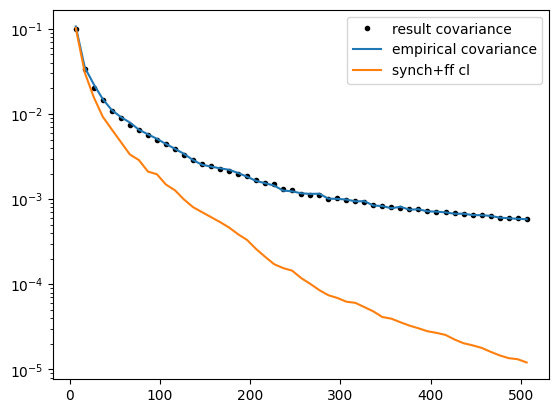

In [112]:
plt.plot(leff,C_result[:,10,10],'k.', label="result covariance")
plt.plot(leff,c_hat[:,10,10], label="empirical covariance")
# plt.plot(leff,c_model[:,10,10], label="model covaraince")
# plt.plot(leff, hi_binned[:,10,10], label="hi covaraince")
# plt.plot(leff,noise_binned[:,10,10], label="noise covariance")
plt.plot(leff, fgds_binned[:,10,10], label="synch+ff cl")
plt.yscale('log')
plt.legend()

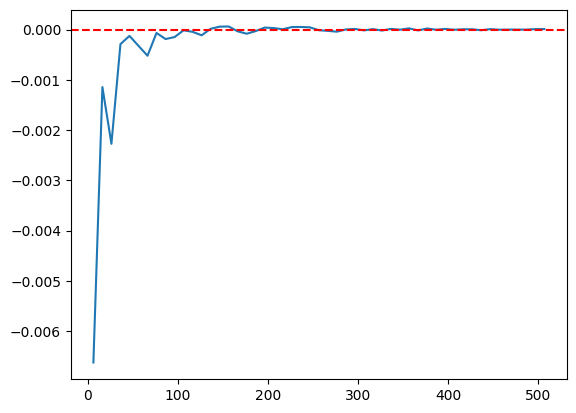

In [113]:
plt.plot(leff,(C_result[:,10,10] - c_hat[:,10,10]))
# plt.plot(leff,(C_result[:,10,10] - fgds_binned[:,10,10]))
# plt.ylim(-0.5,0.5)) 
plt.axhline(0, color='r', linestyle='--')